<a href="https://colab.research.google.com/github/pratibha77118/23-Homework7G5/blob/error_correction/hexagon_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize
from matplotlib.lines import Line2D


In [26]:
KE2 = 197 / 137 # eV-nm   Coulomb force charge
ALPHA = 1.09e3  # eV      parameter of model
RHO = 0.0321    # nm      parameter of model
B = 1.0         # eV      regular
C = 0.01

In [27]:
#Helpful solution to convert itertools combinations to numpy arrays here:
## https://stackoverflow.com/questions/33282369/convert-itertools-array-into-numpy-array
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.vij_[pos] = KE2 / self.rij[pos] + B*(C/self.rij[pos])**12
        self.vij_[neg] =-KE2 / self.rij[neg] + ALPHA*np.exp(-self.rij[neg]/RHO) + B*(C/self.rij[neg])**12
        return self.vij_

    def v(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.vij())

    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)

    def set_vals(self, vals ):
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)


    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.v()

In [28]:
a = 0.31

r_na = np.array( [ [-2*a,0,0], [-0.5*a, 0.8*a, 0], [a,0,0],[-0.5*a,-0.8*a,0] ] )
r_cl = np.array( [ [-a,0,0],[-a, -a, 0],[0.5*a, 0.8*a, 0],[0.5*a,-0.8*a, 0] ] )


cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.v() )

initial Na positions:
 [[-0.62   0.     0.   ]
 [-0.155  0.248  0.   ]
 [ 0.31   0.     0.   ]
 [-0.155 -0.248  0.   ]]
initial Cl positions:
 [[-0.31   0.     0.   ]
 [-0.31  -0.31   0.   ]
 [ 0.155  0.248  0.   ]
 [ 0.155 -0.248  0.   ]]
initial positions flattened shape:
 [-0.62   0.     0.    -0.155  0.248  0.     0.31   0.     0.    -0.155
 -0.248  0.    -0.31   0.     0.    -0.31  -0.31   0.     0.155  0.248
  0.     0.155 -0.248  0.   ]
initial V  : -20.703866574890796


In [29]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[-4.07605854e-01 -1.71799971e-01  1.64871912e-02]
 [-2.50061323e-01  2.52001608e-01 -1.59501757e-02]
 [ 1.74819526e-01  9.40201584e-02 -1.65365068e-02]
 [ 1.72744330e-02 -3.29780415e-01  1.59285165e-02]
 [-4.16831841e-01  7.28231328e-02  3.91209251e-04]
 [-2.27793698e-01 -3.38564457e-01  2.29245980e-02]
 [-4.99494071e-03  2.60783003e-01 -2.29685185e-02]
 [ 1.84040298e-01 -1.50601382e-01 -4.21398645e-04]]
Final potential: -27.782435079081257


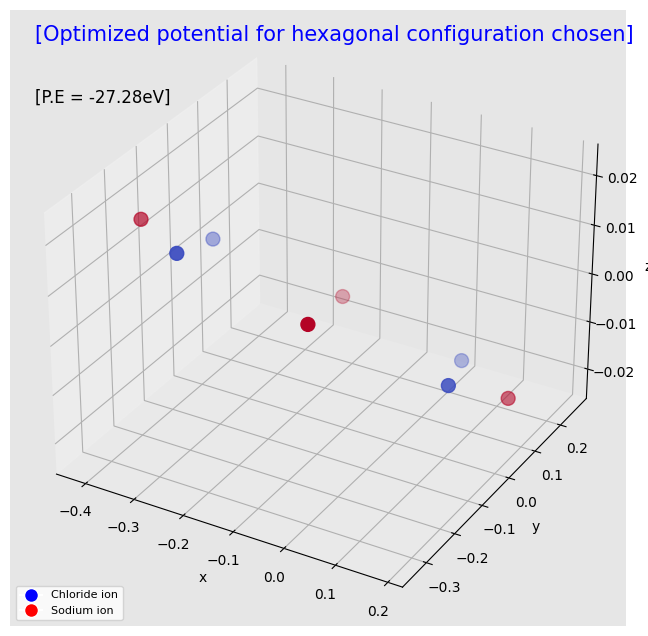

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]

marker_size = 100
scatter = ax.scatter(x, y, z, c=charges, cmap='coolwarm', s=marker_size)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Set a bright color map for better visibility
ax.set_facecolor((0.9, 0.9, 0.9))  # Adjust background color

# You can also customize the color bar for better understanding
#cbar = fig.colorbar(scatter)
#cbar.set_label('Charges')
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Chloride ion'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Sodium ion')]

ax.legend(handles=legend_elements, loc='lower left', fontsize=8)
ax.text2D(0.04, 0.95, "[Optimized potential for hexagonal configuration chosen]", transform=ax.transAxes, color = 'blue', fontsize=15)
ax.text2D(0.04, 0.85, "[P.E = -27.28eV]", transform=ax.transAxes, color = 'black', fontsize=12)

# Customize plot appearance further if needed
plt.show()
